In [1]:
# https://statmodeling.stat.columbia.edu/2013/12/19/happy-birthday/
# https://fivethirtyeight.com/features/some-people-are-too-superstitious-to-have-a-baby-on-friday-the-13th/

import pandas as pd
from fbprophet import Prophet

# from
# https://github.com/fivethirtyeight/data/blob/master/births/US_births_2000-2014_SSA.csv
df = pd.read_csv('../../data/US_births_2000-2014_SSA.csv')
df.head()

,year,month,date_of_month,day_of_week,births
0,2000,1,1,6,9083
1,2000,1,2,7,8006
2,2000,1,3,1,11363
3,2000,1,4,2,13032
4,2000,1,5,3,12558


In [2]:
df['ds'] = pd.to_datetime(df.drop(['day_of_week', 'births'], axis=1).rename({'date_of_month': 'day'}, axis=1))
df.head()

,year,month,date_of_month,day_of_week,births,ds
0,2000,1,1,6,9083,2000-01-01
1,2000,1,2,7,8006,2000-01-02
2,2000,1,3,1,11363,2000-01-03
3,2000,1,4,2,13032,2000-01-04
4,2000,1,5,3,12558,2000-01-05


<AxesSubplot:>

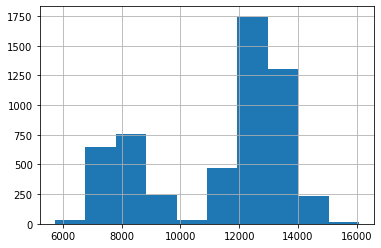

In [3]:
df.births.hist()

<AxesSubplot:>

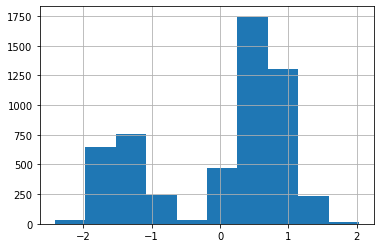

In [4]:
df['y'] = (df.births - df.births.mean()) / df.births.std()
df.y.hist()

In [5]:
df['t'] = (df.ds - df.ds.min()).dt.days
t_range = tuple(df.t.agg(['min', 'max']))
t_range

(0, 5478)

In [67]:
import tensorflow as tf

import sys; sys.path.append('../../')
from ryan_adams import RyanAdams, LinearTrend, Seasonality

model = RyanAdams(
    trends=[
        LinearTrend(n_items=1, name='trend', t_range=t_range, changepoint_penalty=1)
    ],
    seasonalities=[
        Seasonality(n_items=1, order=10, period=365.25, name='yearly'),
        Seasonality(n_items=1, order=3, period=7, name='weekly'),
    ],
)

In [68]:
model._model.summary()

Model: "model_31"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 t (InputLayer)                 [(None, 1)]          0           []                               
                                                                                                  
 trend (LinearTrend)            (None, 1)            22          ['t[0][0]']                      
                                                                                                  
 yearly (Seasonality)           (None, 1)            20          ['t[0][0]']                      
                                                                                                  
 weekly (Seasonality)           (None, 1)            6           ['t[0][0]']                      
                                                                                           

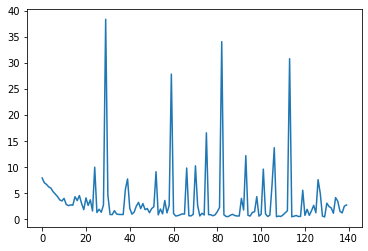

In [69]:
import matplotlib.pyplot as plt


history = model._model.fit(
    df[['t']], df.y,
    batch_size=32,
    epochs=150,
    verbose=0,
)

plt.plot(history.history['loss'][10:])

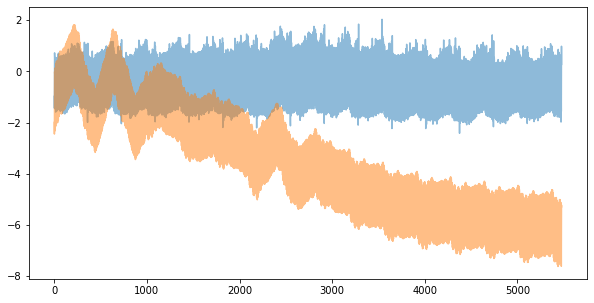

In [70]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(df.y, alpha=.5)
ax.plot(model.predict(df[['t']]), alpha=.5)

/Users/dantegates/virtualenvs/v3.8/lib/python3.8/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['id'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/Users/dantegates/virtualenvs/v3.8/lib/python3.8/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['id'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/Users/dantegates/virtualenvs/v3.8/lib/python3.8/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['id'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


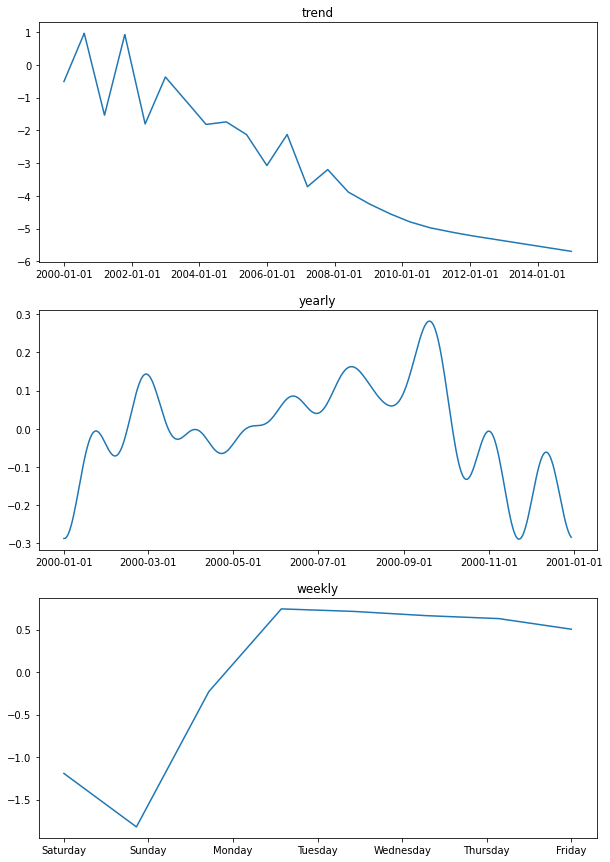

In [71]:
from ryan_adams import plot_model_components

plot_model_components(model, t0=df.ds.min(), subplots_kws={'figsize': (10, 15)})